In [16]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from hurry.filesize import size, si
import re

sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
FIG_PARAMS = dict(
    fig_size=(14, 5),
    label_size=20,
    legend_size=14,
    legend_title_size=17,
    title_size=26,
    annot_size=16,
    tick_size=16,
    marker_size=2,
    fill_alpha=0.15,
)

FIG_PARAMS_HEATMAP = dict(
    fig_size=(12, 8),
    label_size=20,
    legend_size=14,
    legend_title_size=17,
    title_size=26,
    annot_size=16,
    tick_size=16,
    marker_size=2,
    fill_alpha=0.15,
)


X_NAMES = {
    "representation": "Represetation type",
    "model": "Model type"
}

Y_NAMES = {
    "fscore": "$F_1$",
    "mae": "$MAE$",
    "inference_mean_time": "Inference time\n[$ms$]",
    "inference_time": "Inference time\n[$ms$]",
    "memory_complexity": "Disk space needed\n[$bytes$]"
}

rep2name = {
    "whole_signal_waveforms": "Whole signal/nwaveforms",
    "whole_signal_features": "Whole signal/nfeatures",
    "agg_beat_waveforms": "Aggregated beat/nwaveforms",
    "agg_beat_features": "Aggregated beat/nfeatures",
}

rep2name_for_table = {
    "whole_signal_waveforms": "WSW",
    "whole_signal_features": "WSF",
    "agg_beat_waveforms": "ABW",
    "agg_beat_features": "ABF",
}

model2name = {
    "LGBM": "LGBM",
    "Regression": "Reg",
    "Decision Tree": "DT",
    "CNN": "CNN",
    "MLP": "MLP"
}

# **Load results csv to df**

In [231]:
results = pd.read_csv("final_results.csv")
drop_cols = ["Name", "State", "Created", "Runtime", "test/auroc", "val/fscore", "val/auroc", "inference_std_time", "val/mae", "fit_time"]
rename_cols = {"test/fscore": "fscore", "test/mae": "mae", "inference_mean_time": "inference_time"}
results = results.drop(drop_cols, axis=1).rename(columns=rename_cols)
results['representation'] = results['representation'].apply(lambda rep: rep2name_for_table[rep])
results['model'] = results['model'].apply(lambda model: model2name[model])

# **Split results df into different datasets dfs**

In [232]:
get_ds_results = lambda ds_name: results.query(f"dataset == '{ds_name}'").drop("dataset", axis=1).sort_values(by=["model", "representation"]).reset_index(drop=True).dropna(axis=1)

ptbxl_results = get_ds_results("ptbxl")
sleep_edf_results = get_ds_results("sleep_edf")
mimic_results = get_ds_results("mimic")

# ptbxl_results['memory_complexity'].apply(lambda size_bytes: size(size_bytes, system=si))

In [233]:
def compare_results(data, x="representation", y="fscore", hue="model", axes=None):    
    return_fig = False
    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=FIG_PARAMS['fig_size'])
        return_fig = True
    
    ax1, ax2 = axes
    
    sns.barplot(data=data, x=x, y=y, hue=hue, ax=ax1)
    sns.barplot(data=data, x=x, y=y, hue=hue, ax=ax2)
    
    ax1.legend(
        bbox_to_anchor=(1.02, 1), loc='upper left', 
        borderaxespad=0, fontsize=FIG_PARAMS['legend_size'],
        title=X_NAMES[hue],
        title_fontsize=FIG_PARAMS['legend_title_size']
    )
    
    ax1.set_ylim(90, 100)  # outliers only
    ax2.set_ylim(0, 25)  # most of the data

    # hide the spines between ax and ax2
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    d = .008  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    for ax in axes:
        ax.set_xlabel(X_NAMES[x], fontsize=FIG_PARAMS["label_size"])
        ax.set_ylabel(Y_NAMES[y], fontsize=FIG_PARAMS["label_size"])
        # ax.tick_params(axis="x", labelrotation=15)
        ax.tick_params(axis="both", labelsize=FIG_PARAMS["tick_size"])
    plt.close()
    if return_fig:
        return fig


def compare_results_2(data, x="representation", y="fscore", hue="model", ax=None):    
    return_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=FIG_PARAMS['fig_size'])
        return_fig = True
        
    sns.barplot(data=data, x=x, y=y, hue=hue, ax=ax)
    ax.legend(
        bbox_to_anchor=(1.02, 1), loc='upper left', 
        borderaxespad=0, fontsize=FIG_PARAMS['legend_size'],
        title=X_NAMES[hue],
        title_fontsize=FIG_PARAMS['legend_title_size']
    )
    ax.set_xlabel(X_NAMES[x], fontsize=FIG_PARAMS["label_size"])
    ax.set_ylabel(Y_NAMES[y], fontsize=FIG_PARAMS["label_size"])
    # ax.tick_params(axis="x", labelrotation=15)
    ax.tick_params(axis="both", labelsize=FIG_PARAMS["tick_size"])
    plt.close()
    if return_fig:
        return fig

def get_comparison_figs(results_df, y="fscore", prefix=""):
    params = dict(data=results_df, y=y)
    models_fig = compare_results(x="representation", hue="model", **params)
    representation_fig = compare_results(x="model", hue="representation", **params)
    return {
        f"{prefix}models": models_fig,
        f"{prefix}reps": representation_fig
    }

def plot_results_heatmap(results_df, x="model", y="representation", z="fscore", ax=None):    
    df = results_df.pivot(y, x, z)
    fmt = "" if z == "memory_complexity" else ".3g"
    return_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2*len(df)))
        return_fig = True
    axx = sns.heatmap(
        df, 
        cmap='coolwarm', 
        annot=True, fmt=fmt, annot_kws={"fontsize": FIG_PARAMS_HEATMAP['tick_size']},
        cbar=True,
        ax=ax, 
        square=False
    )
    cb = axx.collections[0].colorbar
    cb.ax.tick_params(labelsize=FIG_PARAMS_HEATMAP['legend_size'])
    cb.ax.set_title(Y_NAMES[z], fontsize=FIG_PARAMS_HEATMAP['legend_title_size'])

    ax.set_xlabel(X_NAMES[x], fontsize=FIG_PARAMS_HEATMAP["label_size"])
    ax.set_ylabel(X_NAMES[y], fontsize=FIG_PARAMS_HEATMAP["label_size"])
    ax.tick_params(axis="x", labelrotation=15)
    ax.tick_params(axis="y", labelrotation=0)
    ax.tick_params(axis="both", labelsize=FIG_PARAMS_HEATMAP["tick_size"])
    plt.close()
    if return_fig:
        return fig
    
def get_all_heatmaps(results_df, x="model", y="representation", pred_qual_metric="fscore"):
    pred_qual_fig = plot_results_heatmap(results_df, z=pred_qual_metric)
    inference_time_fig = plot_results_heatmap(results_df, z="inference_time")
    memory_complexity_fig = plot_results_heatmap(results_df, z="memory_complexity")
    return {
        f"pred_qual_heatmap": pred_qual_fig,
        f"infer_time_heatmap": inference_time_fig,
        f"mem_comp_heatmap": memory_complexity_fig
    }


def get_all_comparison_figs(results_df, pred_qual_metric="fscore", prefix=""):
    pred_qual_figs = get_comparison_figs(results_df, y=pred_qual_metric, prefix="pred_qual_")
    inference_time_figs = get_comparison_figs(results_df, y="inference_time", prefix="infer_time_")
    memory_complexity_figs = get_comparison_figs(results_df, y="memory_complexity", prefix="mem_comp_")
    heatmaps = get_all_heatmaps(results_df, x="model", y="representation", pred_qual_metric=pred_qual_metric)
    figs = {**pred_qual_figs, **inference_time_figs, **memory_complexity_figs, **heatmaps}
    figs = {f"{prefix}{name}": fig for name, fig in figs.items()}
    return figs

In [345]:
results = pd.read_csv("results_3.csv").drop(["Name", "State", "Created", "Runtime"], axis=1)
results['representation'] = results['representation'].apply(lambda rep: rep2name[rep])

info = [
    ("ptbxl", "fscore", ptbxl_results),
    ("sleep_edf", "fscore", sleep_edf_results),
    ("mimic", "mae", mimic_results),
]

for ds_name, metric, data in info:
    figs = get_all_comparison_figs(data, pred_qual_metric=metric, prefix=f"{ds_name}_")
    for fig_name, fig in figs.items():
        fig.savefig(f"plots/{fig_name}.pdf", bbox_inches="tight")

/tmp/ipykernel_1489004/1609793725.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = results_df.pivot(y, x, z)
/tmp/ipykernel_1489004/1609793725.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = results_df.pivot(y, x, z)
/tmp/ipykernel_1489004/1609793725.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = results_df.pivot(y, x, z)


In [7]:
ptbxl_figs = get_all_comparison_figs(ptbxl_results, pred_qual_metric='fscore')
sleep_edf_figs = get_all_comparison_figs(sleep_edf_results, pred_qual_metric='fscore')
mimic_figs = get_all_comparison_figs(mimic_results, pred_qual_metric='mae')

/tmp/ipykernel_730155/1830544175.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = results_df.pivot(y, x, z)
/tmp/ipykernel_730155/1830544175.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = results_df.pivot(y, x, z)
/tmp/ipykernel_730155/1830544175.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = results_df.pivot(y, x, z)


In [234]:
def plot_datasets_comparison(data_to_plot, x="representation", hue="model"):    
    if hue == "model":
        width_ratios = [4, 2, 4]
        order = ["WSW", "WSF", "ABW", "ABF"]
        hue_order = ["LGBM", "CNN", "Decision Tree", "MLP", "Regression"]
        hue_order = [model2name[model] for model in hue_order]
    else:
        width_ratios = [4, 3, 4]
        order = ["LGBM", "CNN", "Decision Tree", "MLP", "Regression"]
        order = [model2name[model] for model in order]
        hue_order = ["WSW", "WSF", "ABW", "ABF"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5.), gridspec_kw=dict(width_ratios=width_ratios))
    
    ylabels = []
    for ax, (title_name, data, metric) in zip(axes, data_to_plot):
        sns.barplot(
            data=data, 
            x=x, y=metric, hue=hue, 
            ax=ax, 
            hue_order=hue_order[:2] if title_name == "Sleep-EDF" and hue == "representation"  else hue_order,
            order=order[:2] if title_name == "Sleep-EDF" and hue == "model"  else order,
        )
        ax.get_legend().remove()
        # ax.tick_params(axis="x", labelrotation=15)
        ax.set_title(title_name, fontsize=FIG_PARAMS['title_size'])
        ax.set_xlabel(X_NAMES[x], fontsize=FIG_PARAMS['label_size'])
        ax.set_ylabel(Y_NAMES[metric], fontsize=FIG_PARAMS['label_size'])
        ylabels.append(Y_NAMES[metric])
        ax.tick_params(axis="both", labelsize=FIG_PARAMS["tick_size"])
        if metric == "mae":
            bounds = (10, 25)
        elif metric == "fscore":
            bounds = (0.3, 0.8)
        elif metric == "inference_time":
            bounds = (0, 0.9)
        ax.set_ylim(*bounds)

    lines, labels = [ax.get_legend_handles_labels() for ax in fig.axes][0]
    fig.legend(lines, labels, bbox_to_anchor=(0.5, 1.09), loc='upper center', ncol=8, fontsize=FIG_PARAMS['legend_size'])#, title=X_NAMES[hue])
    axes[0].set_xlabel("")
    axes[2].set_xlabel("")
    
    if len(set(ylabels)) == 1:
        axes[1].set_ylabel("")
        axes[2].set_ylabel("")

    plt.tight_layout()
    return fig

In [235]:
def plot_datasets_comparison(data_to_plot, x="representation", hue="model", broke_axis=[2]):    
    if hue == "model":
        width_ratios = [4, 2, 4]
        order = ["WSW", "WSF", "ABW", "ABF"]
        hue_order = ["LGBM", "CNN", "Decision Tree", "MLP", "Regression"]
        hue_order = [model2name[model] for model in hue_order]
    else:
        width_ratios = [4, 3, 4]
        order = ["LGBM", "CNN", "Decision Tree", "MLP", "Regression"]
        order = [model2name[model] for model in order]
        hue_order = ["WSW", "WSF", "ABW", "ABF"]
    fig, all_axes = plt.subplots(2, 3, figsize=(18, 4.5), gridspec_kw=dict(width_ratios=width_ratios, height_ratios=[1, 4]))
    
    ylabels = []
    all_axes = all_axes.T
    for i, (axes, (title_name, data, metric)) in enumerate(zip(all_axes, data_to_plot)):
        if i not in broke_axis:
            gs = axes[0].get_gridspec()
            # remove the underlying axes
            for ax in axes:
                ax.remove()
            axes = fig.add_subplot(gs[:, i])
            sns.barplot(
                data=data, 
                x=x, y=metric, hue=hue, 
                ax=axes, 
                hue_order=hue_order[:2] if title_name == "Sleep-EDF" and hue == "representation"  else hue_order,
                order=order[:2] if title_name == "Sleep-EDF" and hue == "model"  else order,
            )
            axes.set_title(title_name, fontsize=FIG_PARAMS['title_size'])
            axes.set_xlabel(X_NAMES[x], fontsize=FIG_PARAMS['label_size'])
            axes.set_ylabel(Y_NAMES[metric], fontsize=FIG_PARAMS['label_size'])
            axes.set_ylabel(Y_NAMES[metric], fontsize=FIG_PARAMS['label_size'])
            axes.get_legend().remove()
            ylabels.append(Y_NAMES[metric])
            axes.tick_params(axis="both", labelsize=FIG_PARAMS["tick_size"])
            axes.tick_params(axis="both", labelsize=FIG_PARAMS["tick_size"])
            if metric == "mae":
                bounds = (10, 100)
            elif metric == "fscore":
                bounds = (0.3, 0.8)
            elif metric == "inference_time":
                bounds = (0, 30)
            elif metric == "memory_complexity":
                bounds = (0, 3e7)
            axes.set_ylim(*bounds)
        else:
            ax1, ax2 = axes
            sns.barplot(
                data=data, 
                x=x, y=metric, hue=hue, 
                ax=ax1, 
                hue_order=hue_order[:2] if title_name == "Sleep-EDF" and hue == "representation"  else hue_order,
                order=order[:2] if title_name == "Sleep-EDF" and hue == "model"  else order,
            )
            sns.barplot(
                data=data, 
                x=x, y=metric, hue=hue, 
                ax=ax2, 
                hue_order=hue_order[:2] if title_name == "Sleep-EDF" and hue == "representation"  else hue_order,
                order=order[:2] if title_name == "Sleep-EDF" and hue == "model"  else order,
            )
            if metric == "mae":
                bounds_1, bounds_2 = (90, 100), (15, 25)
            elif metric == "fscore":
                bounds_1, bounds_2 = (0.9, 1.0), (0.2, 0.9)
            elif metric == "inference_time":
                bounds_1, bounds_2 = (0.49, 30), (0, 0.5)
            elif metric == "memory_complexity":
                bounds_1, bounds_2 = (1e7, 3.5e7), (0, 1e7)
            ax1.set_ylim(*bounds_1)  # outliers only
            ax2.set_ylim(*bounds_2)  # most of the data

            # hide the spines between ax and ax2
            ax1.spines['bottom'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            ax1.xaxis.tick_top()
            ax1.tick_params(labeltop=False)  # don't put tick labels at the top
            ax2.xaxis.tick_bottom()
            d = .008  # how big to make the diagonal lines in axes coordinates
            # arguments to pass to plot, just so we don't keep repeating them
            kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
            ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

            kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
            ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
            ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
            ax1.get_legend().remove()
            ax2.get_legend().remove()

            ax1.set_title(title_name, fontsize=FIG_PARAMS['title_size'])
            ax2.set_xlabel(X_NAMES[x], fontsize=FIG_PARAMS['label_size'])
            ax1.set_ylabel("")
            ax2.set_ylabel(Y_NAMES[metric], fontsize=FIG_PARAMS['label_size'])

            ylabels.append(Y_NAMES[metric])
            ax1.tick_params(axis="both", labelsize=FIG_PARAMS["tick_size"])
            ax2.tick_params(axis="both", labelsize=FIG_PARAMS["tick_size"])
        

    lines, labels = [ax.get_legend_handles_labels() for ax in fig.axes][0]
    fig.legend(lines, labels, bbox_to_anchor=(0.5, 1.09), loc='upper center', ncol=8, fontsize=FIG_PARAMS['legend_size'])#, title=X_NAMES[hue])
    all_axes[0][0].set_xlabel("")
    all_axes[1][0].set_xlabel("")
    all_axes[2][0].set_xlabel("")
    all_axes[0][1].set_xlabel("")
    all_axes[2][1].set_xlabel("")
    
    if len(set(ylabels)) == 1:
        all_axes[1][0].set_ylabel("")
        all_axes[2][0].set_ylabel("")
        all_axes[1][1].set_ylabel("")
        all_axes[2][1].set_ylabel("")

    plt.tight_layout()
    return fig

# **Prediction quality plots**

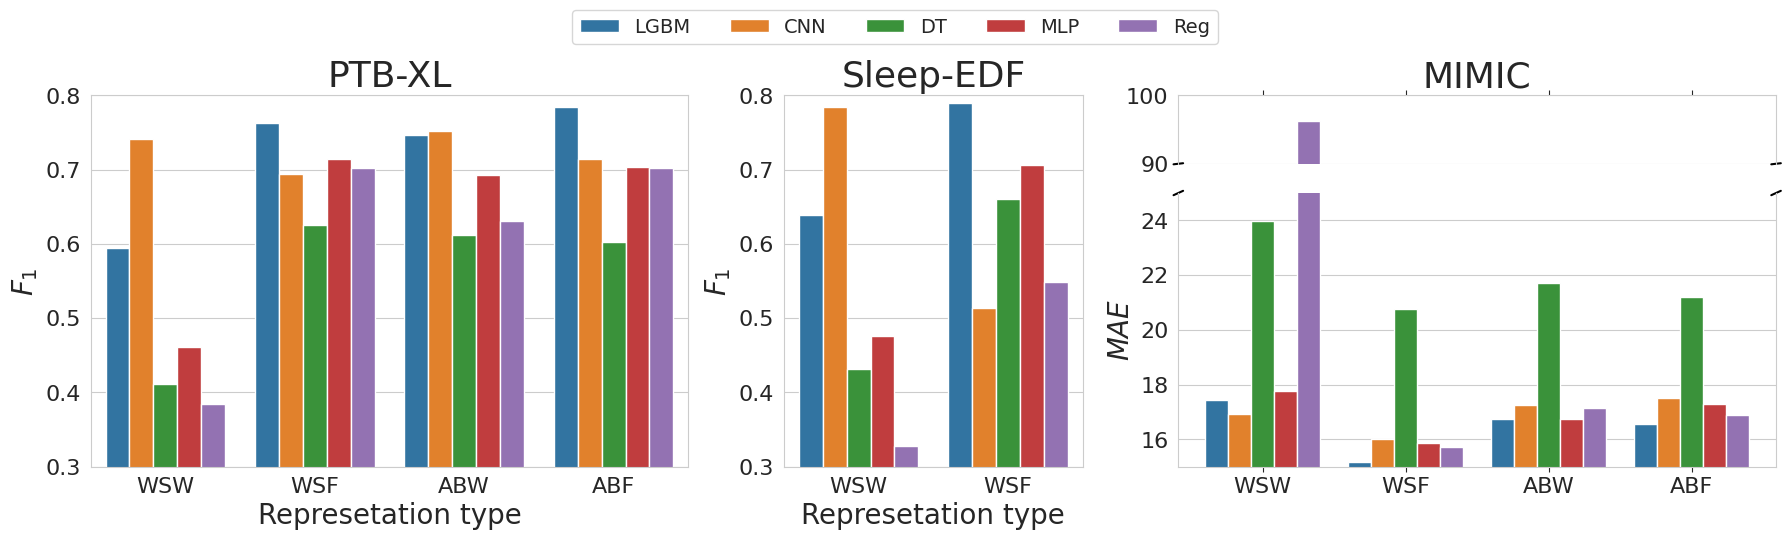

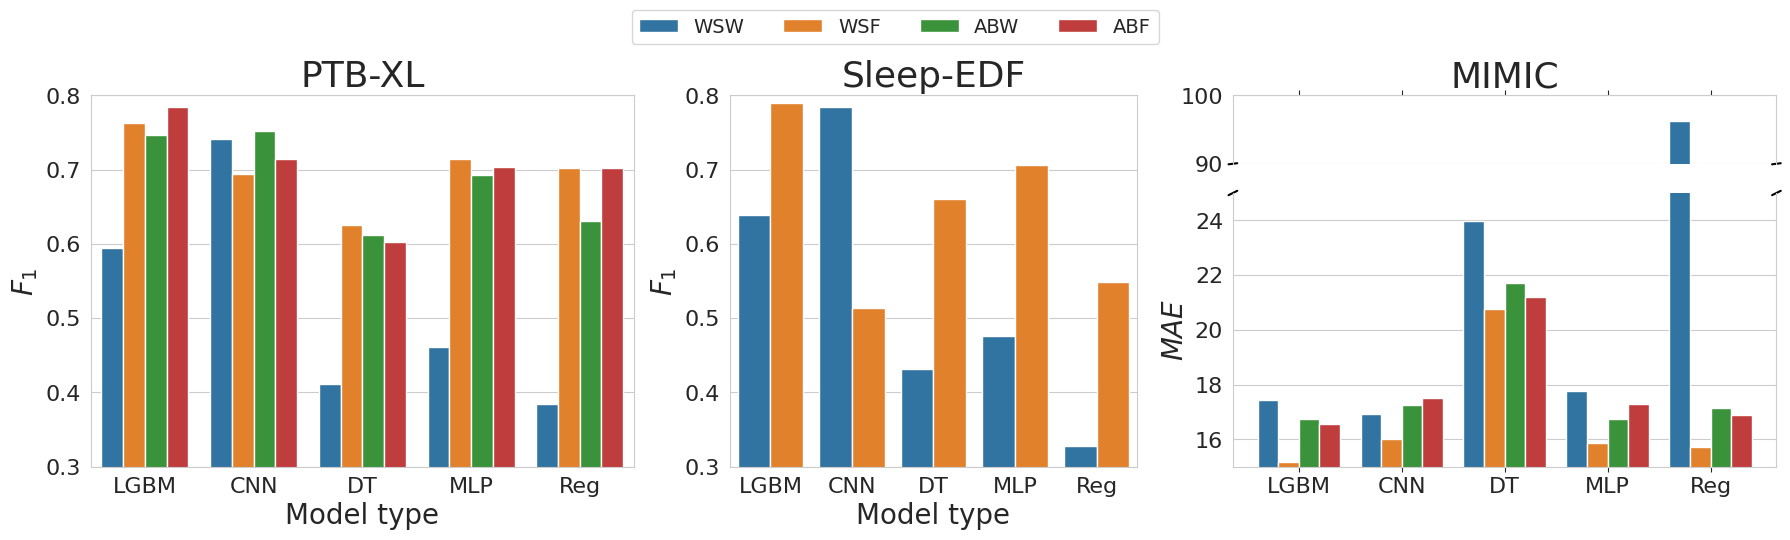

In [161]:
data_to_plot = [
    ("PTB-XL", ptbxl_results, "fscore"),
    ("Sleep-EDF", sleep_edf_results, "fscore"),
    ("MIMIC", mimic_results, "mae"),
]

pred_qual_model_figs = plot_datasets_comparison(data_to_plot, x="representation", hue="model", broke_axis=[2])
pred_qual_reps_figs = plot_datasets_comparison(data_to_plot, x="model", hue="representation", broke_axis=[2])

# **Inference time**

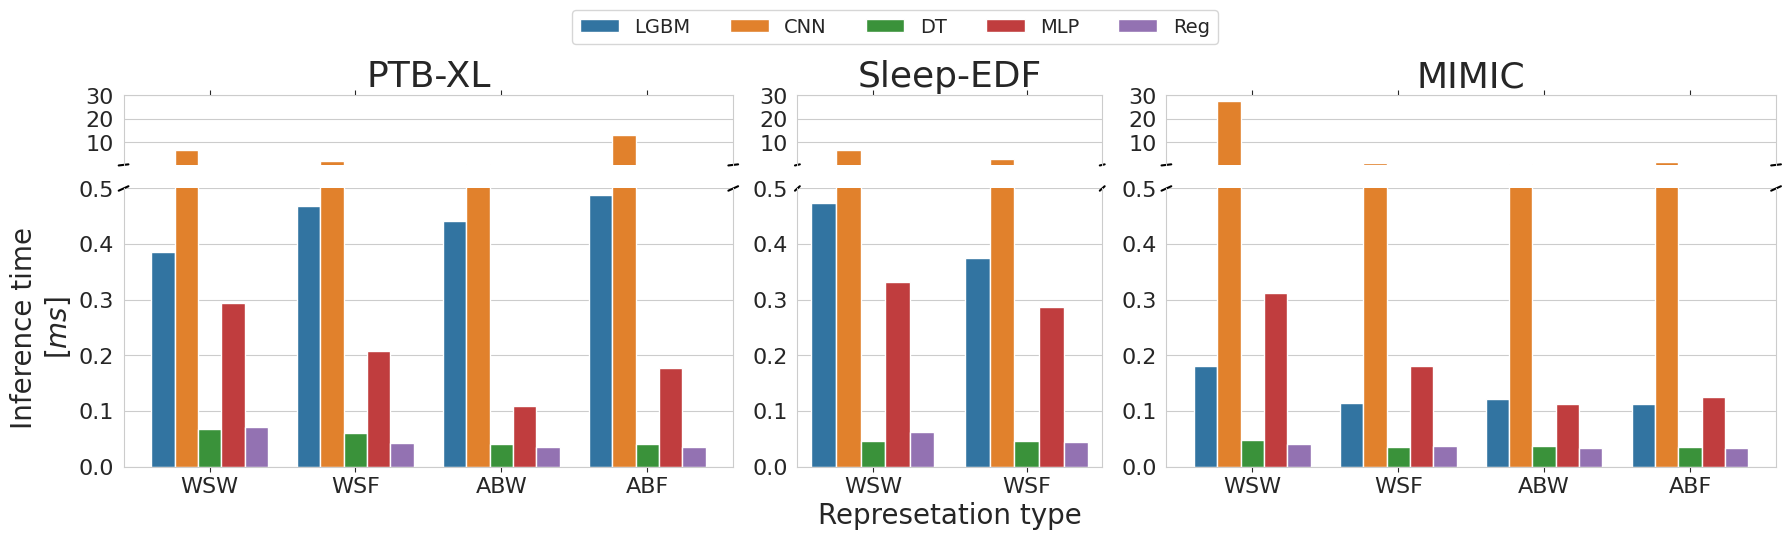

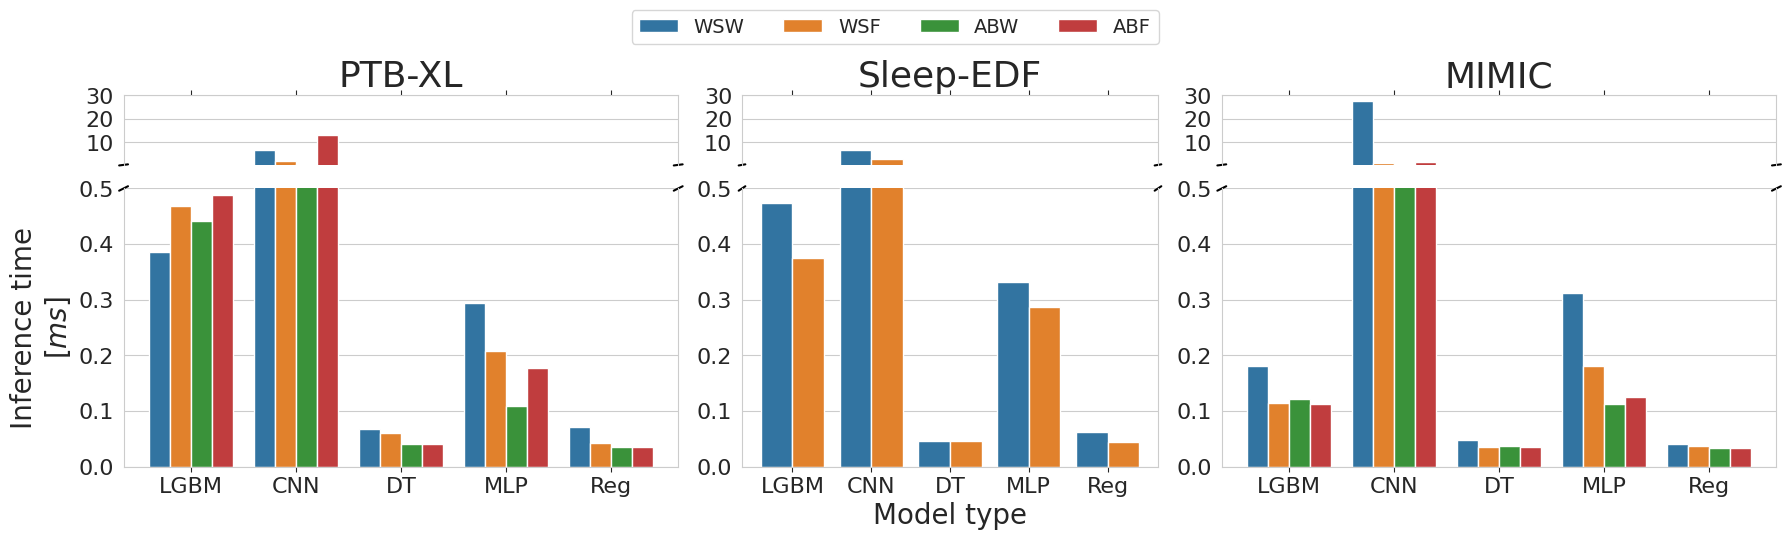

In [162]:
data_to_plot = [
    ("PTB-XL", ptbxl_results, "inference_time"),
    ("Sleep-EDF", sleep_edf_results, "inference_time"),
    ("MIMIC", mimic_results, "inference_time"),
]

inference_time_model_figs = plot_datasets_comparison(data_to_plot, x="representation", hue="model", broke_axis=[0, 1, 2])
inference_time_reps_figs = plot_datasets_comparison(data_to_plot, x="model", hue="representation", broke_axis=[0, 1, 2])

# **Memory complexity**

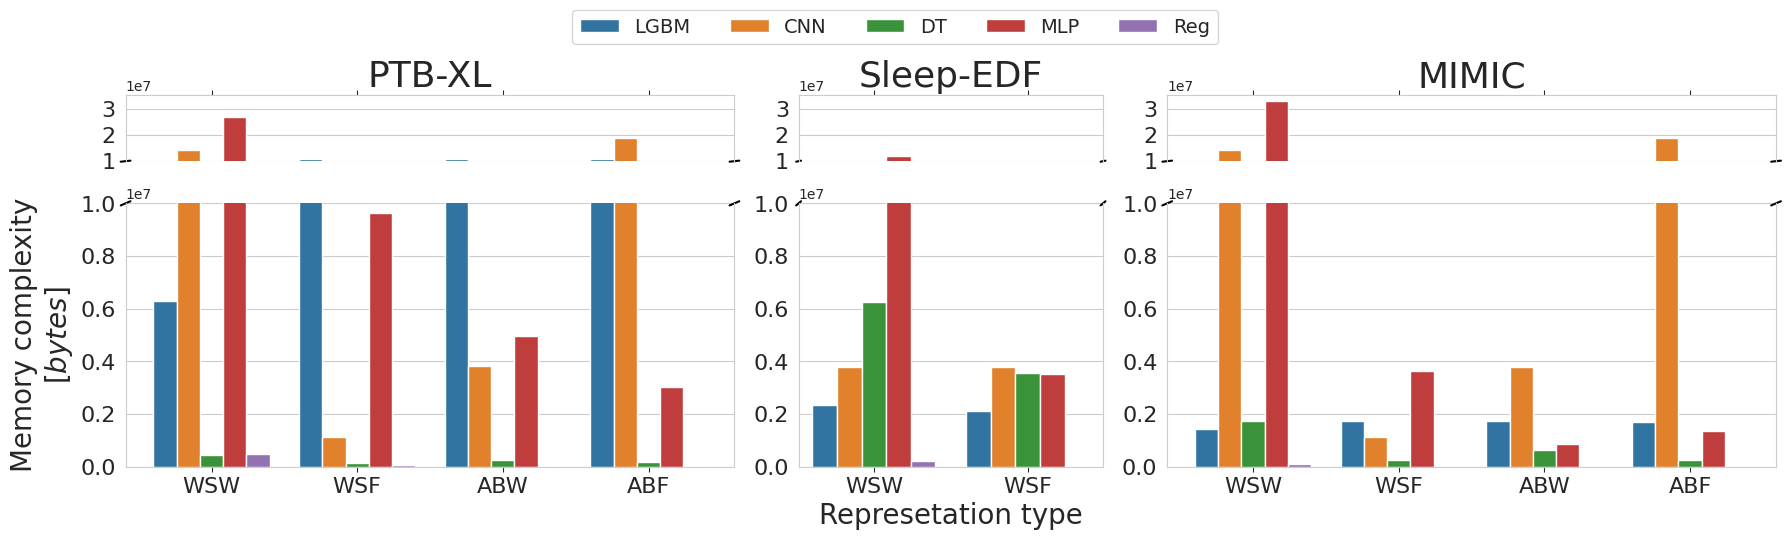

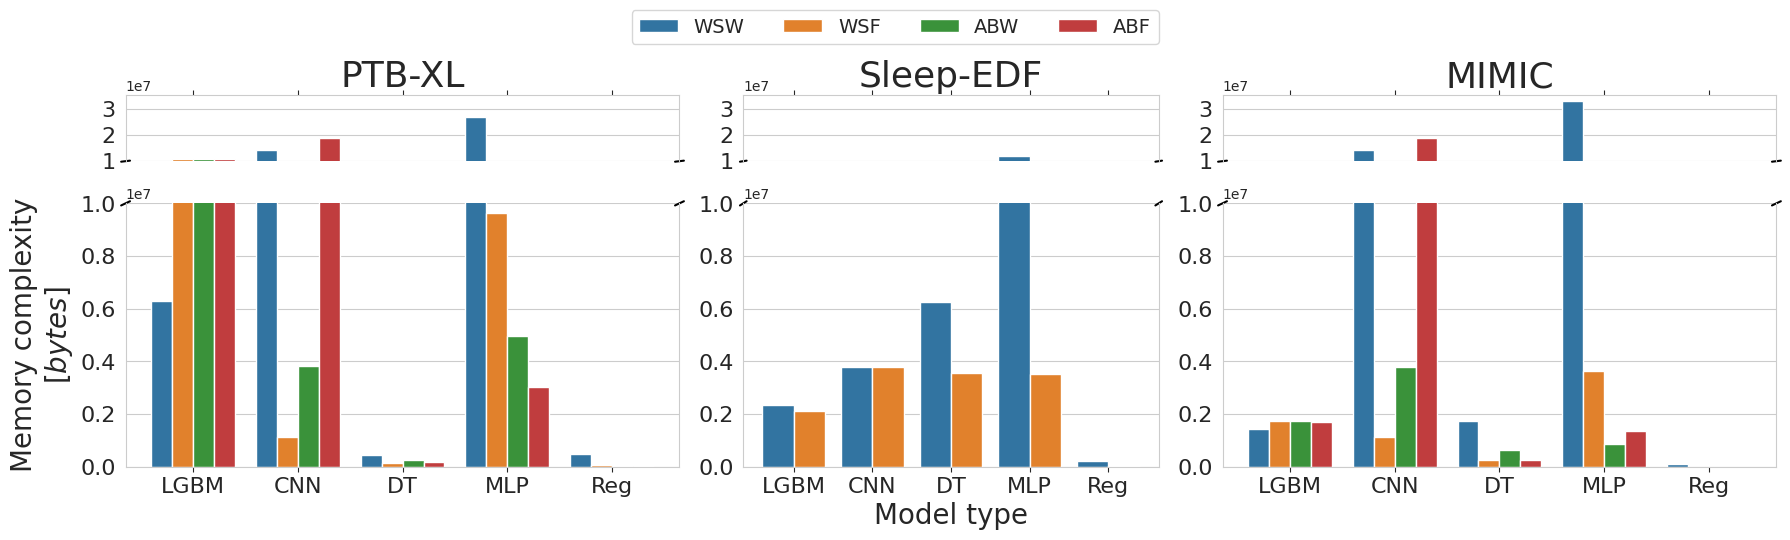

In [163]:
data_to_plot = [
    ("PTB-XL", ptbxl_results, "memory_complexity"),
    ("Sleep-EDF", sleep_edf_results, "memory_complexity"),
    ("MIMIC", mimic_results, "memory_complexity"),
]

memory_complexity_model_figs = plot_datasets_comparison(data_to_plot, x="representation", hue="model", broke_axis=[0, 1, 2])
memory_complexity_reps_figs = plot_datasets_comparison(data_to_plot, x="model", hue="representation", broke_axis=[0, 1, 2])

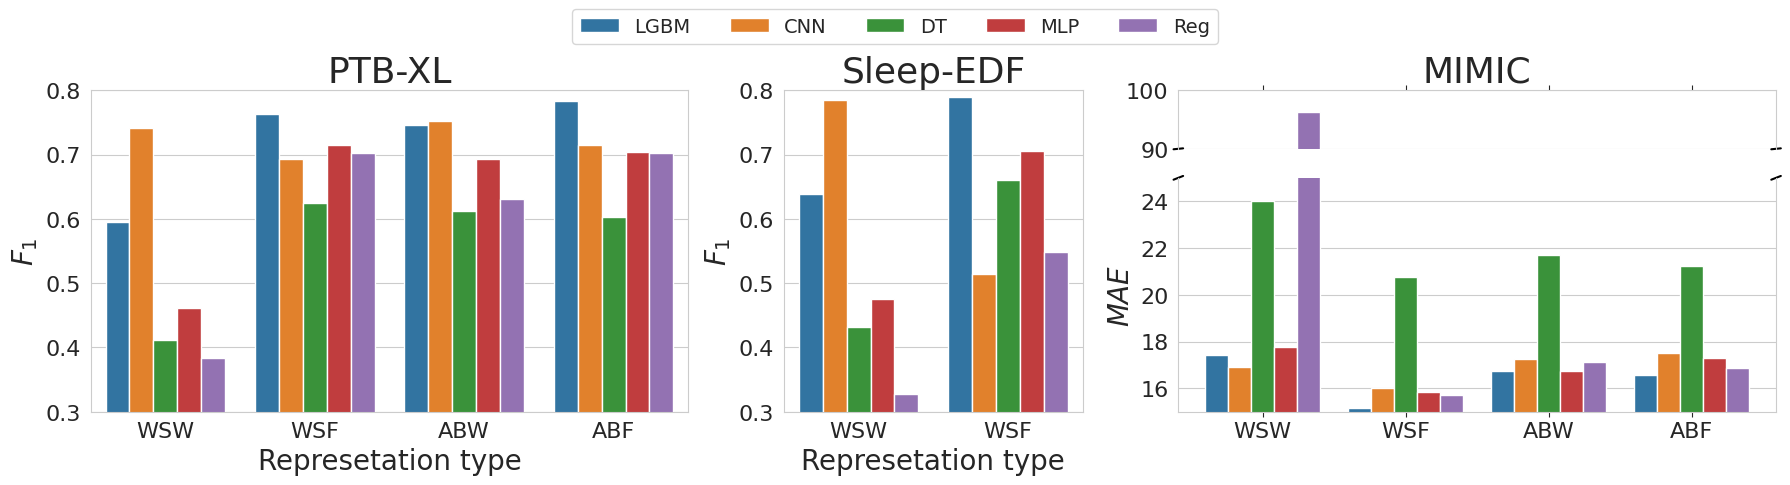

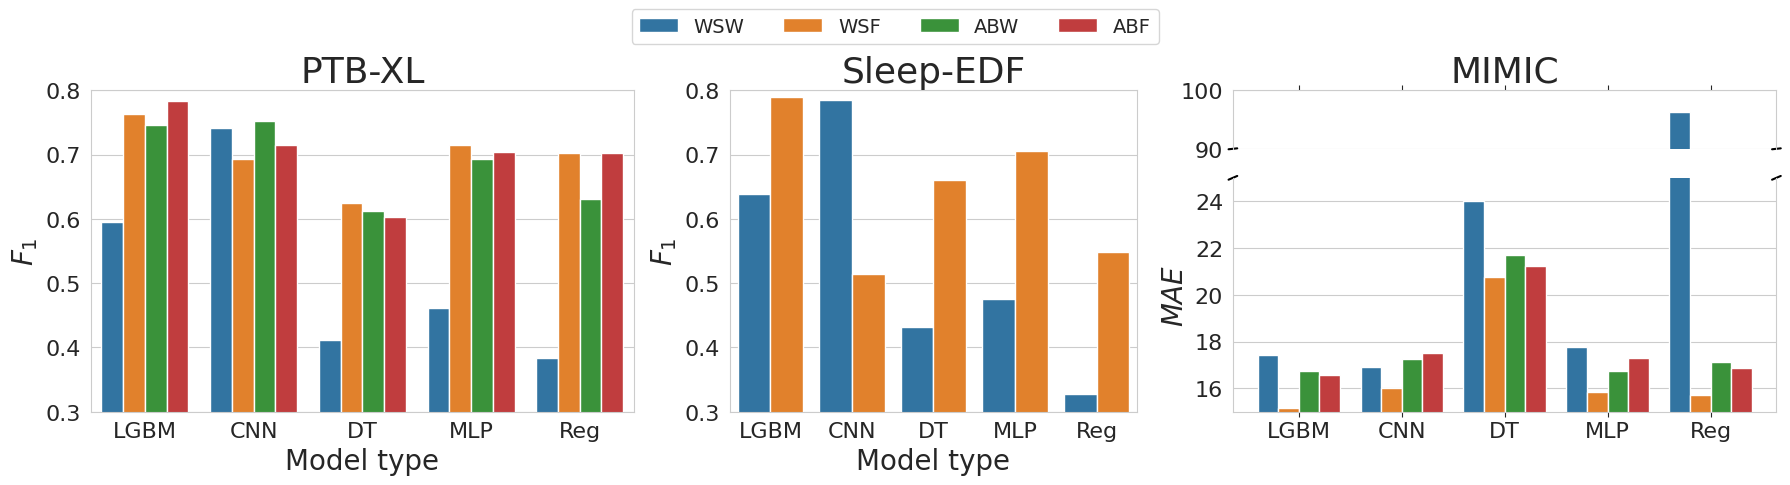

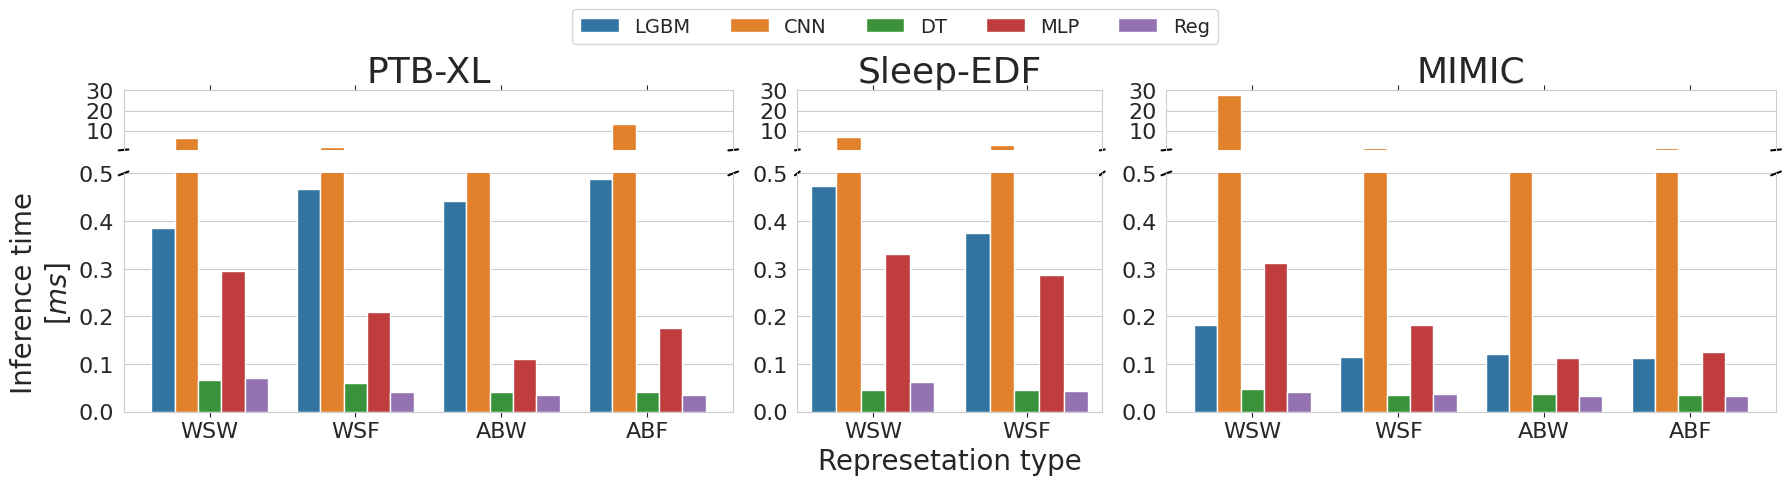

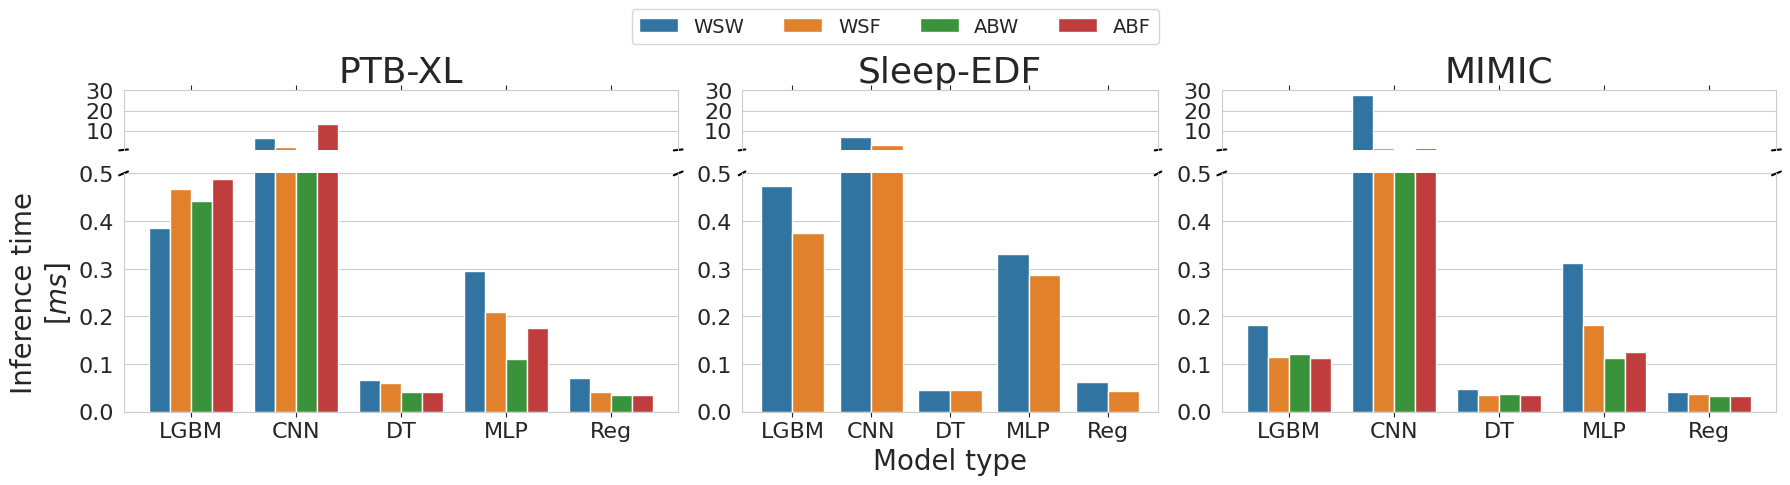

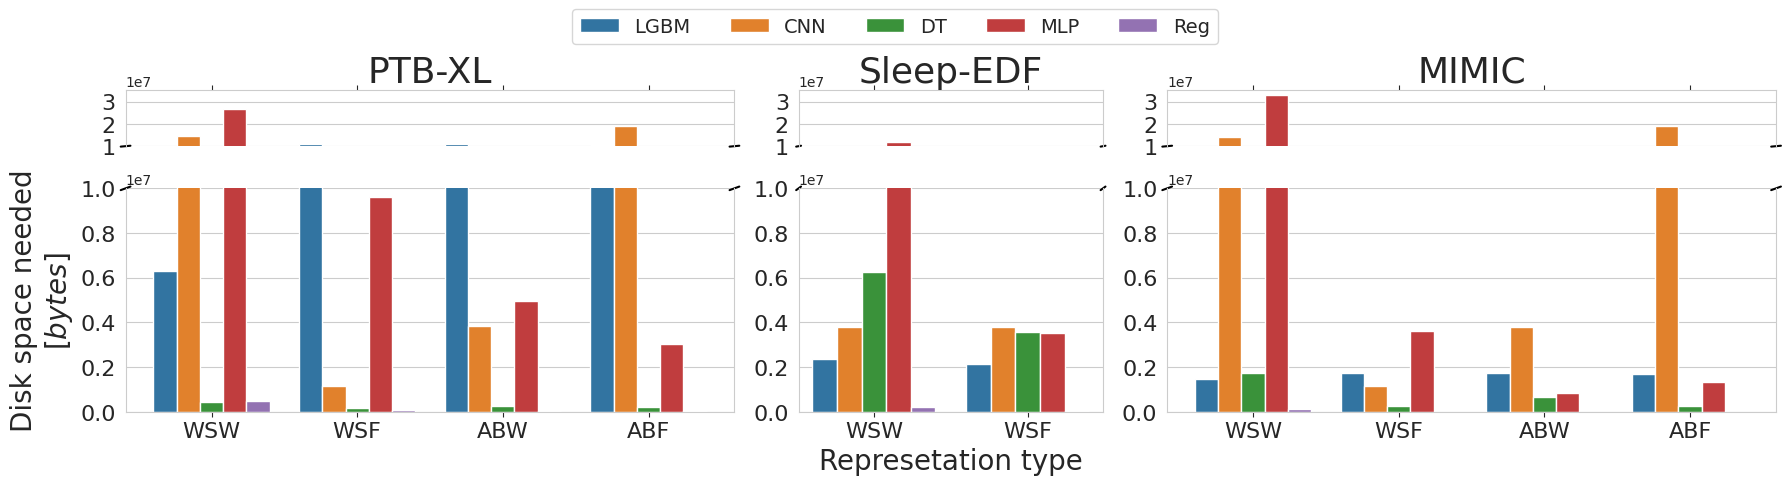

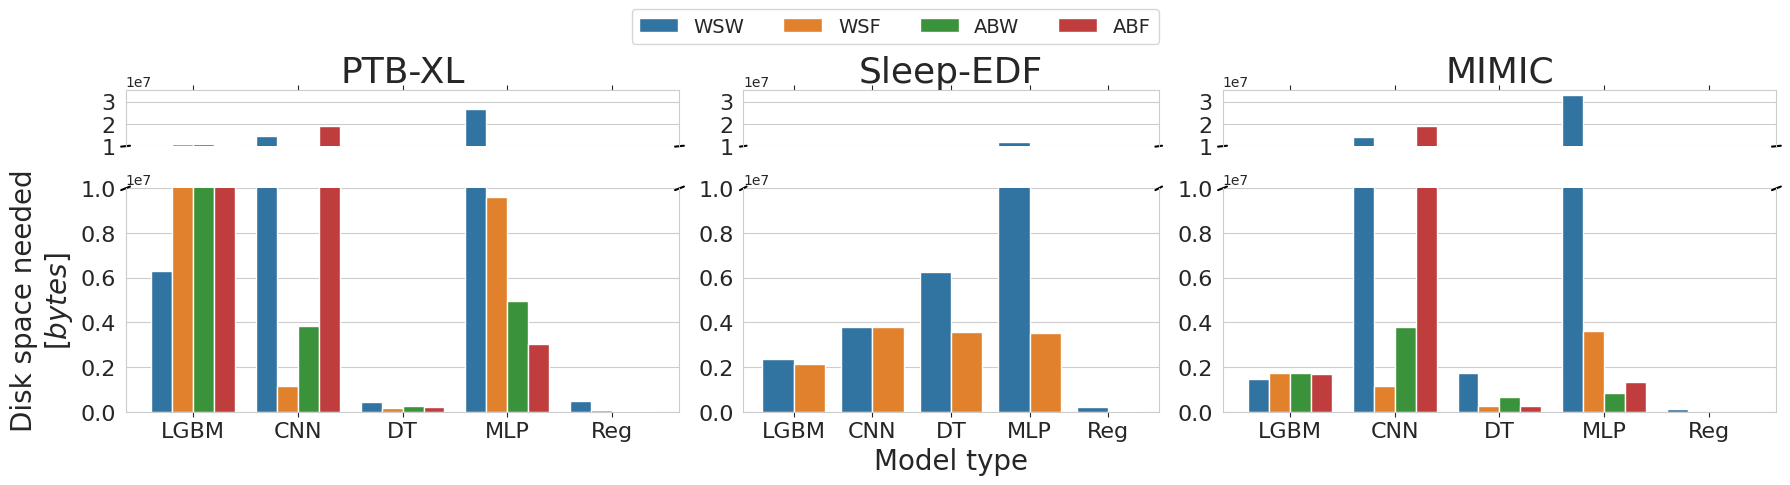

In [236]:
ptbxl_data = ["PTB-XL", ptbxl_results]
sleep_edf_data = ["Sleep-EDF", sleep_edf_results]
mimic_data = ["MIMIC", mimic_results]

pred_qual_plot_data = [ptbxl_data + ["fscore"], sleep_edf_data + ["fscore"], mimic_data + ["mae"]]
inference_time_plot_data = [data + ["inference_time"] for data in [ptbxl_data, sleep_edf_data, mimic_data]]
memory_complexity_plot_data = [data + ["memory_complexity"] for data in [ptbxl_data, sleep_edf_data, mimic_data]]

pred_qual_model_figs = plot_datasets_comparison(pred_qual_plot_data, x="representation", hue="model", broke_axis=[2])
pred_qual_reps_figs = plot_datasets_comparison(pred_qual_plot_data, x="model", hue="representation", broke_axis=[2])
inference_time_model_figs = plot_datasets_comparison(inference_time_plot_data, x="representation", hue="model", broke_axis=[0, 1, 2])
inference_time_reps_figs = plot_datasets_comparison(inference_time_plot_data, x="model", hue="representation", broke_axis=[0, 1, 2])
memory_complexity_model_figs = plot_datasets_comparison(memory_complexity_plot_data, x="representation", hue="model", broke_axis=[0, 1, 2])
memory_complexity_reps_figs = plot_datasets_comparison(memory_complexity_plot_data, x="model", hue="representation", broke_axis=[0, 1, 2])

figs = {
    'pred_qual_model': pred_qual_model_figs,
    'pred_qual_reps': pred_qual_reps_figs,
    
    'inference_time_model': inference_time_model_figs,
    'inference_time_reps': inference_time_reps_figs,
    
    'memory_complexity_model': memory_complexity_model_figs,
    'memory_complexity_reps': memory_complexity_reps_figs,
}

for fig_name, fig in figs.items():
    fig.savefig(f"plots/{fig_name}.pdf", bbox_inches="tight")

In [168]:
results

,dataset,model,representation,fscore,inference_time,memory_complexity,mae
0,sleep_edf,CNN,WSF,0.514026,3.050863,3M,NaN
1,sleep_edf,CNN,WSW,0.784654,6.767928,3M,NaN
2,sleep_edf,MLP,WSF,0.705681,0.286670,3M,NaN
3,sleep_edf,MLP,WSW,0.475857,0.331671,11M,NaN
4,sleep_edf,Reg,WSF,0.548402,0.043738,19K,NaN
5,sleep_edf,Reg,WSW,0.327471,0.061630,216K,NaN
6,sleep_edf,DT,WSF,0.660512,0.046156,3M,NaN
7,sleep_edf,DT,WSW,0.431110,0.046313,6M,NaN
8,sleep_edf,LGBM,WSF,0.789092,0.374315,2M,NaN
9,sleep_edf,LGBM,WSW,0.638311,0.474045,2M,NaN


# **Results tables**

In [169]:
results = pd.read_csv("final_results.csv")
drop_cols = ["Name", "State", "Created", "Runtime", "test/auroc", "val/fscore", "val/auroc", "inference_std_time", "val/mae", "fit_time"]
rename_cols = {"test/fscore": "fscore", "test/mae": "mae", "inference_mean_time": "inference_time"}
results = results.drop(drop_cols, axis=1).rename(columns=rename_cols)
results['representation'] = results['representation'].apply(lambda rep: rep2name_for_table[rep])
results['model'] = results['model'].apply(lambda model: model2name[model])

In [172]:
df = results.copy()

df['memory_complexity'] = df['memory_complexity'].apply(lambda byte_size: size(byte_size, system=si))
df.rename(
    columns={
        "inference_time": "Inference time [$ms$]",
        "memory_complexity": "Memory complexity [$bytes$]",
        "fscore": "F1", 
        "mae": "MAE"
    },
    inplace=True
)
df = df.set_index(["dataset", "model", "representation"])[["F1", "MAE", "Inference time [$ms$]", "Memory complexity [$bytes$]"]].sort_index()

In [173]:
df

F1        MAE  Inference time [$ms$]  \
dataset   model representation                                               
mimic     CNN   ABF                  NaN  17.502003               1.662061   
                ABW                  NaN  17.251602               0.795349   
                WSF                  NaN  16.011894               1.274178   
                WSW                  NaN  16.917870              27.651680   
          DT    ABF                  NaN  21.209055               0.036025   
                ABW                  NaN  21.695879               0.036551   
                WSF                  NaN  20.758475               0.035948   
                WSW                  NaN  23.990183               0.047613   
          LGBM  ABF                  NaN  16.567608               0.113242   
                ABW                  NaN  16.727171               0.121674   
                WSF                  NaN  15.172240               0.114097   
                WSW                  NaN  17.429288               0.181260   
          MLP   ABF                  NaN  17.301420               0.125973   
                ABW                  NaN  16.747292               0.112453   
                WSF                  NaN  15.862592               0.181256   
                WSW                  NaN  17.774059               0.311674   
          Reg   ABF                  NaN  16.879934               0.033484   
                ABW                  NaN  17.141483               0.032898   
                WSF                  NaN  15.714669               0.037057   
                WSW                  NaN  96.310081               0.040732   
ptbxl     CNN   ABF             0.714875        NaN              13.241784   
                ABW             0.751667        NaN               0.830942   
                WSF             0.693854        NaN               2.134600   
                WSW             0.741650        NaN               6.621858   
          DT    ABF             0.602561        NaN               0.041055   
                ABW             0.612241        NaN               0.041295   
                WSF             0.625497        NaN               0.060007   
                WSW             0.411625        NaN               0.066913   
          LGBM  ABF             0.783754        NaN               0.488749   
                ABW             0.746647        NaN               0.441983   
                WSF             0.763095        NaN               0.468014   
                WSW             0.595026        NaN               0.385618   
          MLP   ABF             0.703810        NaN               0.176708   
                ABW             0.692574        NaN               0.109954   
                WSF             0.714400        NaN               0.208523   
                WSW             0.461792        NaN               0.294471   
          Reg   ABF             0.702673        NaN               0.034544   
                ABW             0.630995        NaN               0.034655   
                WSF             0.701931        NaN               0.042188   
                WSW             0.383953        NaN               0.071026   
sleep_edf CNN   WSF             0.514026        NaN               3.050863   
                WSW             0.784654        NaN               6.767928   
          DT    WSF             0.660512        NaN               0.046156   
                WSW             0.431110        NaN               0.046313   
          LGBM  WSF             0.789092        NaN               0.374315   
                WSW             0.638311        NaN               0.474045   
          MLP   WSF             0.705681        NaN               0.286670   
                WSW             0.475857        NaN               0.331671   
          Reg   WSF             0.548402        NaN               0.043738   
                WSW             0.327471        NaN         

In [184]:
ptbxl_df = df.loc['ptbxl'].drop("MAE", axis=1).round(3)
sleep_edf_df = df.loc['sleep_edf'].drop("MAE", axis=1).round(3)
mimic_df = df.loc['mimic'].drop("F1", axis=1).round(3)

In [185]:
def get_latex_table(df):
    latex_table = df.to_latex().replace("NaN", "-").replace('\$', '$')
    latex_table =  re.sub(' +', ' ', latex_table)
    return latex_table

In [186]:
ptbxl_table = get_latex_table(ptbxl_df)
sleep_edf_table = get_latex_table(sleep_edf_df)
mimic_table = get_latex_table(mimic_df)

/tmp/ipykernel_730155/3237524066.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex().replace("NaN", "-").replace('\$', '$')


In [187]:
print(ptbxl_table)

\begin{tabular}{llrrl}
\toprule
 & & F1 & Inference time [$ms$] & Memory complexity [$bytes$] \\
model & representation & & & \\
\midrule
CNN & ABF & 0.715 & 13.242 & 18M \\
 & ABW & 0.752 & 0.831 & 3M \\
 & WSF & 0.694 & 2.135 & 1M \\
 & WSW & 0.742 & 6.622 & 14M \\
DT & ABF & 0.603 & 0.041 & 190K \\
 & ABW & 0.612 & 0.041 & 260K \\
 & WSF & 0.625 & 0.060 & 160K \\
 & WSW & 0.412 & 0.067 & 427K \\
LGBM & ABF & 0.784 & 0.489 & 10M \\
 & ABW & 0.747 & 0.442 & 10M \\
 & WSF & 0.763 & 0.468 & 10M \\
 & WSW & 0.595 & 0.386 & 6M \\
MLP & ABF & 0.704 & 0.177 & 3M \\
 & ABW & 0.693 & 0.110 & 4M \\
 & WSF & 0.714 & 0.209 & 9M \\
 & WSW & 0.462 & 0.294 & 26M \\
Reg & ABF & 0.703 & 0.035 & 19K \\
 & ABW & 0.631 & 0.035 & 24K \\
 & WSF & 0.702 & 0.042 & 73K \\
 & WSW & 0.384 & 0.071 & 480K \\
\bottomrule
\end{tabular}



In [188]:
print(sleep_edf_table)

\begin{tabular}{llrrl}
\toprule
 & & F1 & Inference time [$ms$] & Memory complexity [$bytes$] \\
model & representation & & & \\
\midrule
CNN & WSF & 0.514 & 3.051 & 3M \\
 & WSW & 0.785 & 6.768 & 3M \\
DT & WSF & 0.661 & 0.046 & 3M \\
 & WSW & 0.431 & 0.046 & 6M \\
LGBM & WSF & 0.789 & 0.374 & 2M \\
 & WSW & 0.638 & 0.474 & 2M \\
MLP & WSF & 0.706 & 0.287 & 3M \\
 & WSW & 0.476 & 0.332 & 11M \\
Reg & WSF & 0.548 & 0.044 & 19K \\
 & WSW & 0.327 & 0.062 & 216K \\
\bottomrule
\end{tabular}



In [189]:
print(mimic_table)

\begin{tabular}{llrrl}
\toprule
 & & MAE & Inference time [$ms$] & Memory complexity [$bytes$] \\
model & representation & & & \\
\midrule
CNN & ABF & 17.502 & 1.662 & 18M \\
 & ABW & 17.252 & 0.795 & 3M \\
 & WSF & 16.012 & 1.274 & 1M \\
 & WSW & 16.918 & 27.652 & 14M \\
DT & ABF & 21.209 & 0.036 & 240K \\
 & ABW & 21.696 & 0.037 & 651K \\
 & WSF & 20.758 & 0.036 & 261K \\
 & WSW & 23.990 & 0.048 & 1M \\
LGBM & ABF & 16.568 & 0.113 & 1M \\
 & ABW & 16.727 & 0.122 & 1M \\
 & WSF & 15.172 & 0.114 & 1M \\
 & WSW & 17.429 & 0.181 & 1M \\
MLP & ABF & 17.301 & 0.126 & 1M \\
 & ABW & 16.747 & 0.112 & 854K \\
 & WSF & 15.863 & 0.181 & 3M \\
 & WSW & 17.774 & 0.312 & 32M \\
Reg & ABF & 16.880 & 0.033 & 1K \\
 & ABW & 17.141 & 0.033 & 2K \\
 & WSF & 15.715 & 0.037 & 6K \\
 & WSW & 96.310 & 0.041 & 115K \\
\bottomrule
\end{tabular}



In [227]:
data = []
for model in results.model.unique():
    for ds in ["ptbxl", "sleep_edf", "mimic"]:
        asc = True if ds == "mimic" else False
        metric = "MAE" if ds == "mimic" else "F1"
        best_rep = df.loc[ds, model].sort_values(metric, ascending=asc).iloc[0].name
        data.append({"model": model, "ds": ds, "best_rep": best_rep})
        
_df = pd.DataFrame(data)
_df

,model,ds,best_rep
0,CNN,ptbxl,ABW
1,CNN,sleep_edf,WSW
2,CNN,mimic,WSF
3,MLP,ptbxl,WSF
4,MLP,sleep_edf,WSF
5,MLP,mimic,WSF
6,Reg,ptbxl,ABF
7,Reg,sleep_edf,WSF
8,Reg,mimic,WSF
9,DT,ptbxl,WSF


In [228]:
data = []
for rep in results.representation.unique():
    for ds in ["ptbxl", "sleep_edf", "mimic"]:
        if rep in ["ABW", "ABF"] and ds == "sleep_edf":
            continue
        asc = True if ds == "mimic" else False
        metric = "MAE" if ds == "mimic" else "F1"
        best_model = df.loc[ds, :, rep].sort_values(metric, ascending=asc).iloc[0].name
        data.append({"best_model": best_model, "ds": ds, "rep": rep})
        
_df = pd.DataFrame(data)

In [229]:
_df

,best_model,ds,rep
0,LGBM,ptbxl,WSF
1,LGBM,sleep_edf,WSF
2,LGBM,mimic,WSF
3,CNN,ptbxl,WSW
4,CNN,sleep_edf,WSW
5,CNN,mimic,WSW
6,CNN,ptbxl,ABW
7,LGBM,mimic,ABW
8,LGBM,ptbxl,ABF
9,LGBM,mimic,ABF
